In [86]:
import pandas as pd
import xgboost as xgb
import numpy as np
import urllib.request
from itertools import cycle
from scipy import interp
import sklearn.preprocessing
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn_pandas import DataFrameMapper
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.grid_search import GridSearchCV 
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

## Import and Explore Data

In [6]:
#obtain data and reset/rename columns

iris_data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
                        header=None)

iris_column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
iris_data.columns = iris_column_names
iris_class_names = np.unique(iris_data['class'])
iris_data.head(2)

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa


In [7]:
#explore and analyze the data using summary statistics
round(iris_data.ix[:,:4].groupby(iris_data['class']).describe().reset_index(), 3)

,class,level_1,sepal_length,sepal_width,petal_length,petal_width
0,Iris-setosa,count,50.000,50.000,50.000,50.000
1,Iris-setosa,mean,5.006,3.418,1.464,0.244
2,Iris-setosa,std,0.352,0.381,0.174,0.107
3,Iris-setosa,min,4.300,2.300,1.000,0.100
4,Iris-setosa,25%,4.800,3.125,1.400,0.200
5,Iris-setosa,50%,5.000,3.400,1.500,0.200
6,Iris-setosa,75%,5.200,3.675,1.575,0.300
7,Iris-setosa,max,5.800,4.400,1.900,0.600
8,Iris-versicolor,count,50.000,50.000,50.000,50.000
9,Iris-versicolor,mean,5.936,2.770,4.260,1.326


## Explore data through visualizations

/Users/sunkuo/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


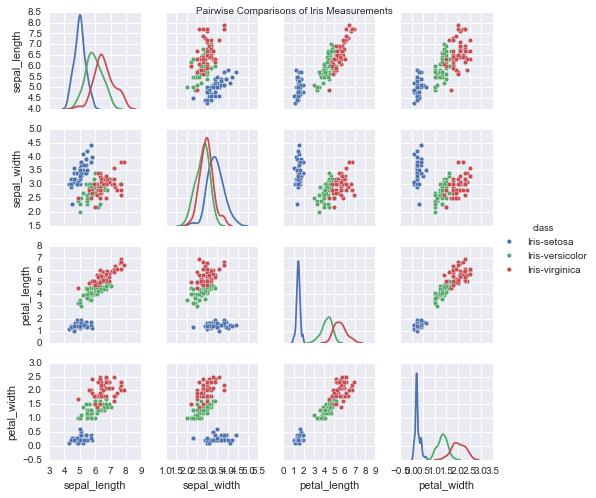

In [8]:
sns.pairplot(iris_data, hue='class', size=1.75, diag_kind='kde')
sns.plt.suptitle('Pairwise Comparisons of Iris Measurements')

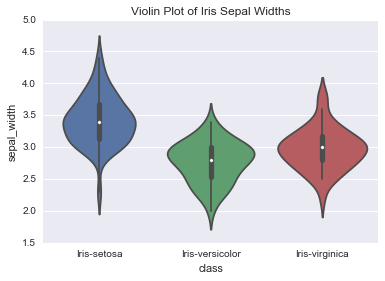

In [9]:
sns.violinplot(x='class', y='sepal_width', data=iris_data)
sns.plt.title('Violin Plot of Iris Sepal Widths')

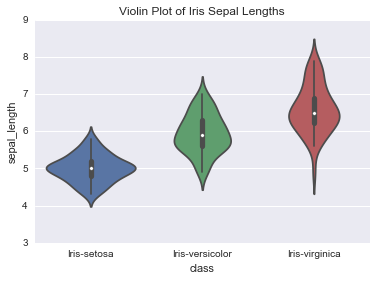

In [10]:
sns.violinplot(x='class', y='sepal_length', data=iris_data)
sns.plt.title('Violin Plot of Iris Sepal Lengths')

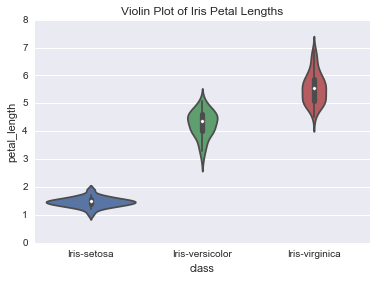

In [11]:
sns.violinplot(x='class', y='petal_length', data=iris_data)
sns.plt.title('Violin Plot of Iris Petal Lengths')

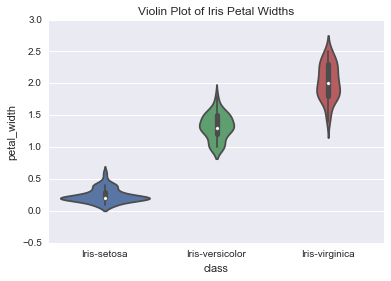

In [12]:
sns.violinplot(x='class', y='petal_width', data=iris_data)
sns.plt.title('Violin Plot of Iris Petal Widths')

## Preprocess Data for Modeling

In [13]:
#Create integer labels for Iris classes
iris_class_dict = {iris_class_names[i]: i for i in range(3)}
iris_data['class_integer'] = iris_data['class'].apply(lambda x: iris_class_dict[x] if x in
                                    iris_class_dict.keys() else np.nan)

In [14]:
#Standardize iris measurements
measurements = iris_data.ix[:, :4]

scaler = pd.DataFrame(sklearn.preprocessing.StandardScaler()\
                      .fit_transform(measurements))

scaler.columns = iris_column_names[:4]

scaler.head(2)

,sepal_length,sepal_width,petal_length,petal_width
0,-0.900681,1.032057,-1.341272,-1.312977
1,-1.143017,-0.124958,-1.341272,-1.312977


In [15]:
#Using pd.get_dummies to binarize the Iris labels
iris_classes_df = pd.get_dummies(iris_data['class'])

In [16]:
#Alternatively use sklearn_pandas DataFrameMapper for preprocessing the data and binarizing the Iris labels
mapper = DataFrameMapper([
        ('class', sklearn.preprocessing.LabelBinarizer())]
    )


classes = pd.DataFrame(mapper.fit_transform(iris_data.copy()))
classes.columns = iris_class_names

In [17]:
#Unstandardized Iris measurements Dataframe
unstandardized_iris_measurements = iris_data.ix[:, :4]

In [18]:
#Create train/test split using standardized measurements
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(
    scaler, iris_classes_df, test_size = 0.33, random_state = 1130)

In [157]:
#Create train/test split using unstandardized measurements
X_train_n_std, X_test_n_std, y_train_n_std, y_test_n_std = train_test_split(
    unstandardized_iris_measurements, iris_classes_df, test_size = 0.33, random_state = 1130)

In [104]:
#Create train/test split using integer labeled classes and scaled measurements
X_train_int_class, X_test_int_class, y_train_int_class, y_test_int_class = train_test_split(
    scaler, iris_data['class_integer'])

In [134]:
#Create function to fit the model and print out CV Scores and hyper paramters
def fit_gb_trees(X, y, n_estimators, learning_rate, max_depth, X_test, y_test):
    gbt = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate,
                    max_depth=max_depth, random_state=50)
    gbt.fit(X, y)
    scores = round(cross_val_score(gbt, X, y).mean(), 4)
    accuracy = round(metrics.accuracy_score(y_test, gbt.predict(X_test)),4)
    print('Accuracy: {} | CV Score: {} | N Est: {} | Learn Rate: {} | Max Depth: {}'.format(accuracy, scores, 
                                        n_estimators, learning_rate, max_depth))
    print
    #return scores

In [135]:
fit_gb_trees(X_train_int_class, y_train_int_class, 100, .2, 1, X_test_int_class, y_test_int_class)

Accuracy: 0.9474 | CV Score: 0.9737 | N Est: 100 | Learn Rate: 0.2 | Max Depth: 1


## Fit Model and Plot AUC Curves

In [77]:
#To plot AUC curve the OneVsRestClassifier must be fit to binarized Class Labels
gbm1 = OneVsRestClassifier(GradientBoostingClassifier())
gbm1.fit(X_train_std, y_train_std)
y_score = gbm1.decision_function(X_test_std)

In [139]:
gbm2 = GradientBoostingClassifier()
gbm2.fit(X_train_int_class, y_train_int_class)
gbm2.feature_importances_

array([ 0.03928211,  0.02064593,  0.23855421,  0.31485109])

In [84]:
#Create dictionaries for true and false positive rates
false_pos_rate = dict()
true_pos_rate = dict()
roc_auc = dict()
n_classes = y_train_std.shape[1]

for i in range(n_classes):
    false_pos_rate[i], true_pos_rate[i], _ = metrics.roc_curve(
        y_test_std.ix[:, i], y_score[:, i])
    roc_auc[i] = metrics.auc(false_pos_rate[i], true_pos_rate[i])
    
# Compute micro-average ROC curve and ROC area
false_pos_rate["micro"], true_pos_rate["micro"], _ = metrics.roc_curve(np.ravel(y_test_std), y_score.ravel())
roc_auc["micro"] = metrics.auc(false_pos_rate["micro"], true_pos_rate["micro"])

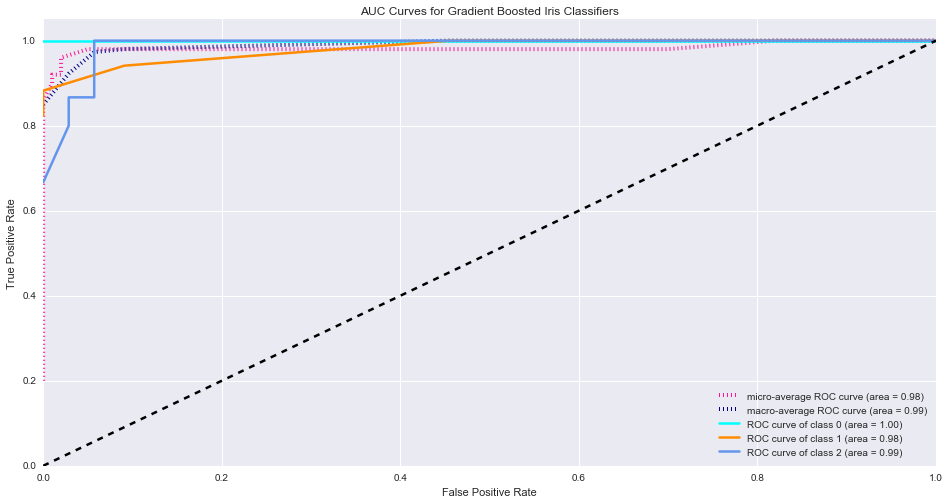

In [100]:
all_fpr = np.unique(np.concatenate([false_pos_rate[i] for i in range(n_classes)]))
lw=2.5

# Then interpolate all ROC curves at this point
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, false_pos_rate[i], true_pos_rate[i])

# # Finally average it and compute AUC
mean_tpr /= n_classes

false_pos_rate["macro"] = all_fpr
true_pos_rate["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(false_pos_rate["macro"], true_pos_rate["macro"])

# # Plot all ROC curves
plt.figure(figsize=(16,8))
plt.plot(false_pos_rate["micro"], true_pos_rate["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(false_pos_rate["macro"], true_pos_rate["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(false_pos_rate[i], true_pos_rate[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC Curves for Gradient Boosted Iris Classifiers')
plt.legend(loc="lower right")

## XGBoost Classifier